# Manipulating date breaks and date labels

In [1]:
import pandas as pd
import numpy as np

from plotnine import *
from plotnine.data import economics

from mizani.breaks import date_breaks
from mizani.formatters import date_format

theme_set(theme_linedraw()) # default theme

%matplotlib inline

Using the `economics` dataset

In [2]:
economics.head()

,date,pce,pop,psavert,uempmed,unemploy
0,1967-07-01,507.4,198712,12.5,4.5,2944
1,1967-08-01,510.5,198911,12.5,4.7,2945
2,1967-09-01,516.3,199113,11.7,4.6,2958
3,1967-10-01,512.9,199311,12.5,4.9,3143
4,1967-11-01,518.1,199498,12.5,4.7,3066


How does the saving rate vary with time?

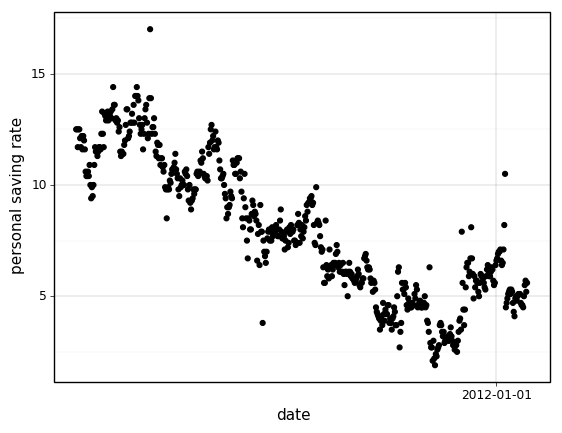

<ggplot: (97654321012345679)>

In [3]:
(ggplot(economics)
 + geom_point(aes('date', 'psavert'))
 + labs(y='personal saving rate')
)

Yikes! the calculated breaks are awful, we need to intervene. We do so using the [date_breaks](https://mizani.readthedocs.io/en/stable/breaks.html#mizani.breaks.date_breaks) and
[date_format](https://mizani.readthedocs.io/en/stable/formatters.html#mizani.formatters.date_format)
functions from mizani.

Set breaks every 10 years

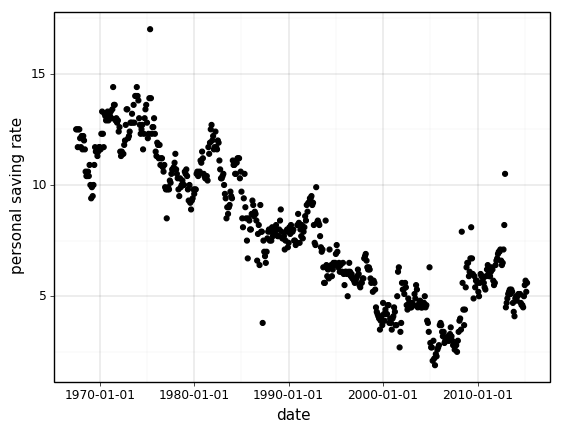

<ggplot: (97654321012345679)>

In [4]:
(ggplot(economics)
 + geom_point(aes('date', 'psavert'))
 + scale_x_datetime(breaks=date_breaks('10 years'))        # new
 + labs(y='personal saving rate')
)

That is better. Since all the breaks are at the beginning of the year, we can omit the month and day.
Using `date_format` we override the format string. For more on the options for the format string see
the [strftime behavior](https://docs.python.org/library/datetime.html#strftime-strptime-behavior).

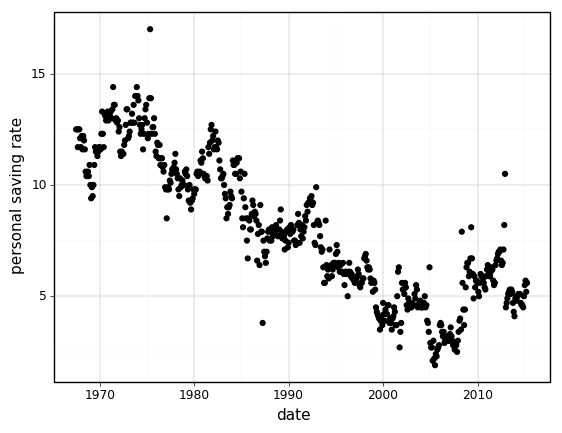

<ggplot: (97654321012345679)>

In [5]:

(ggplot(economics)
 + geom_point(aes('date', 'psavert'))
 + scale_x_datetime(breaks=date_breaks('10 years'), labels=date_format('%Y'))     # modified
 + labs(y='personal saving rate')
)

We can achieve the same result with a custom formating function.

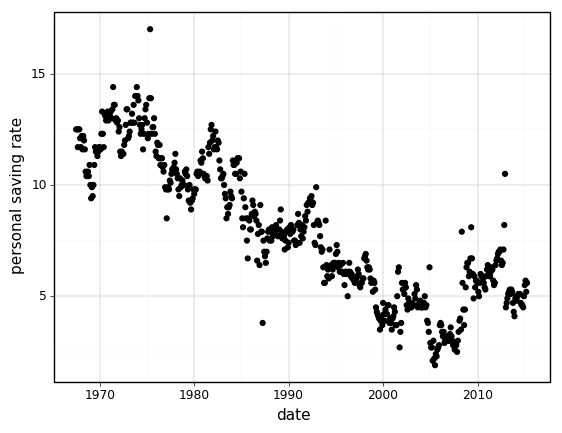

<ggplot: (97654321012345679)>

In [6]:
def custom_date_format1(breaks):
    """
    Function to format the date
    """
    return [x.year if x.month==1 and x.day==1 else "" for x in breaks]

(ggplot(economics)
 + geom_point(aes('date', 'psavert'))
 + scale_x_datetime(                                # modified
     breaks=date_breaks('10 years'),
     labels=custom_date_format1)
 + labs(y='personal saving rate')
)

We can use a custom formatting function to get results that are not obtainable with the `date_format` function.
For example if we have monthly breaks over a handful of years we can mix date formats as follows; specify beginning of the year and every other month. Such tricks can be used reduce overcrowding.

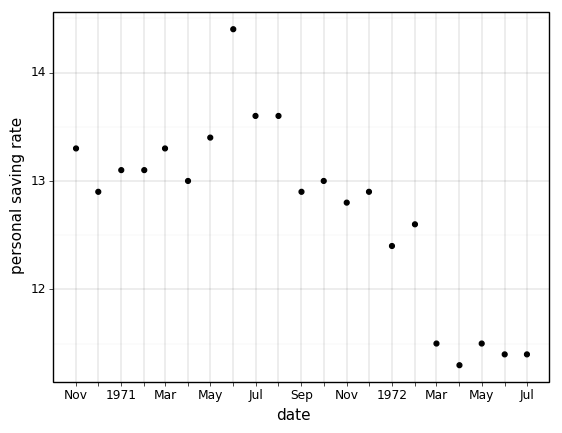

<ggplot: (97654321012345679)>

In [7]:
from datetime import date

def custom_date_format2(breaks):
    """
    Function to format the date
    """
    res = []
    for x in breaks:
        # First day of the year
        if x.month == 1 and x.day == 1:
            fmt = '%Y'
        # Every other month
        elif x.month % 2 != 0:
            fmt = '%b'
        else:
            fmt = ''
            
        res.append(date.strftime(x, fmt))
            
    return res

(ggplot(economics.loc[40:60, :])                            # modified
 + geom_point(aes('date', 'psavert'))
 + scale_x_datetime(
     breaks=date_breaks('1 months'),
     labels=custom_date_format2,
     minor_breaks=[])
 + labs(y='personal saving rate')
)

We removed the labels but not the breaks, leaving behind dangling ticks for the skipped months.
We can fix that by wrapping `date_breaks` around a filtering function.

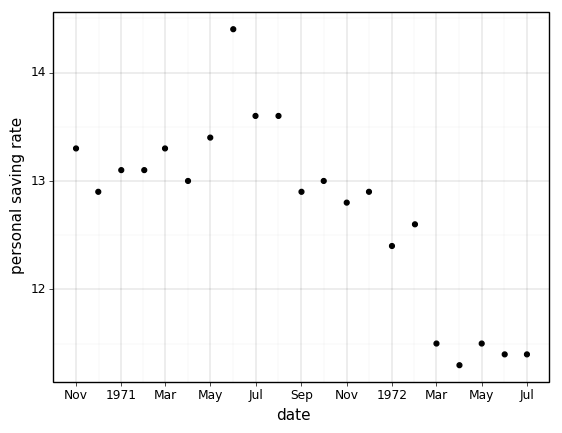

<ggplot: (97654321012345679)>

In [8]:
def custom_date_format3(breaks):
    """
    Function to format the date
    """
    res = []
    for x in breaks:
        # First day of the year
        if x.month == 1:
            fmt = '%Y'
        else:
            fmt = '%b'
            
        res.append(date.strftime(x, fmt))
            
    return res


def custom_date_breaks(width=None):
    """
    Create a function that calculates date breaks
    
    It delegates the work to `date_breaks`
    """
    def filter_func(limits):
        breaks = date_breaks(width)(limits)
        # filter
        return [x for x in breaks if x.month % 2]
    
    return filter_func


(ggplot(economics.loc[40:60, :])
 + geom_point(aes('date', 'psavert'))
 + scale_x_datetime(                                        # modified
     breaks=custom_date_breaks('1 months'),
     labels=custom_date_format3)
 + labs(y='personal saving rate')
)

The breaks and labels functions are tightly coupled to give us exactly what we want.

**Credit:** This example was motivated by the github user [lorin](https://github.com/lorin) (Lorin Hochstein) and his endeavor to control date breaks and date labels.